# Deep Learning
### Week 9: Normalising flows II: NICE, RealNVP & Glow

## Contents

[1. Introduction](#introduction)

[2. NICE / RealNVP](#nicerealnvp)

[3. Bijector subclassing (\*)](#bijector_subclassing)

[4. Glow](#glow)

[References](#references)

<a class="anchor" id="introduction"></a>
## Introduction

In the last week of the course, we introduced the setting for normalising flows, which we used for the problem of density estimation. We saw that the change of variables formula is central to the training of normalising flow models, as it allows us to compute the data likelihood. This also demonstrated that in practical implementations, normalising flow models require two key properties: invertibility, and efficient computation of the Jacobian determinant.

We saw that autoregressive models are one example of normalising flows. These types of models are capable of modelling highly complex data distributions, but come with the potential drawback that running these models at test time can be very slow in practice. 

This week, we'll be going through another popular class of normalising flow models, which are known as the NICE, RealNVP and Glow models. This class of models can actually viewed as a special case of autoregressive models. In practice, they circumvent the problem of the slow inference of autoregressive models.

We will again see how these models can be implemented using TensorFlow and TensorFlow Probability, and also look at how we can create our own subclassed Bijectors, so that we have full flexibility when developing normalising flow models.

<a class="anchor" id="nicerealnvp"></a>
## NICE / RealNVP

#### NICE
NICE stands for "nonlinear independent components estimation", and is a deep learning architecture framework for density estimation tasks. A key motivation for the proposed framework given in the abstract of the original paper ([Dinh 2015](#Dinh15)) is as follows:

> It is based on the idea that a good representation is one in which the data has a distribution that is easy to model. For this purpose, a non-linear deterministic transformation of the data is learned that maps it to a latent space so as to make the transformed data conform to a factorized distribution, i.e., resulting in independent latent variables.

As with many normalising flow examples, a typical choice for a base distribution would be an isotropic Gaussian, which is then transformed by the deep learning model. An important aspect is the efficient calculation of the Jacobian determinant of the transformation. 

In this section, we will describe the NICE architecture, and the RealNVP architecture that is built upon it. We will follow the exposition of the original papers, and think of the forward transformation as acting on the data input example. Note however that this is in contrast to the usual bijector convention of using the forward transformation for sampling, and the inverse transformation for computing log probs.

#### Affine coupling layer
The basic building block of the NICE architecture is the affine coupling layer. Given an input $\mathbf{x}\in\mathbb{R}^D$, we split it into two blocks $(\mathbf{x}_{1:d}, \mathbf{x}_{d+1:D})$, where $d<D$ (usually $d\approx D / 2$), and apply a transformation of the form

$$
\begin{align}
\mathbf{z}_{1:d} &= \mathbf{x}_{1:d},\tag{1}\\
\mathbf{z}_{d+1:D} &= \mathbf{x}_{d+1:D} + t(\mathbf{x}_{1:d}),\tag{2}\\
\end{align}
$$

where $t:\mathbb{R}^d\mapsto\mathbb{R}^{D-d}$ is an arbitrarily complex function, such as a neural network. It is easy to see that the coupling layer as above has an identity Jacobian matrix, and is trivially invertible:

$$
\begin{align}
\mathbf{x}_{1:d} &= \mathbf{z}_{1:d},\\
\mathbf{x}_{d+1:D} &= \mathbf{z}_{d+1:D} - t(\mathbf{z}_{1:d}).\\
\end{align}
$$

Several coupling layers can be composed together to obtain a more complex, layered transformation. Note that a coupling layer leaves part of its input unchanged, and so the roles of the two subsets should be interchanged in alternating layers. 

If we examine the Jacobian, we can see that at least three coupling layers are needed to allow all dimensions to influence each other (this is left as an exercise for the reader). In the NICE paper, networks were composed with four coupling layers.

#### RealNVP
RealNVP stands for real-valued, non-volume preserving ([Dinh et al 2017](#Dinh17)). It was a follow-up work to the NICE paper, in which the affine coupling layer was modified as follows:

$$
\begin{align}
\mathbf{z}_{1:d} &= \mathbf{x}_{1:d},\tag{3}\\
\mathbf{z}_{d+1:D} &= \mathbf{x}_{d+1:D}\odot \exp(s(\mathbf{x}_{1:d})) + t(\mathbf{x}_{1:d}),\tag{4}\\
\end{align}
$$

where $s$ and $t$ stand for scale and translation, and are both functions that map from $\mathbb{R}^d$ to $\mathbb{R}^{D-d}$. The name RealNVP emphasises the fact that the transformation \eqref{realnvp_acl1}-\eqref{realnvp_acl2} is no longer volume-preserving, as is the case with \eqref{nice_acl1}-\eqref{nice_acl2}, due to the additional scaling provided by the term $\exp(s(\mathbf{x}_{1:d}))$. We use the network output $s(\mathbf{x}_{1:d})$ as a log-scale parameter for numerical stability.

As before, the inverse transformation is no more complex than the forward propagation:

$$
\begin{align}
\mathbf{x}_{1:d} &= \mathbf{z}_{1:d},\tag{5}\\
\mathbf{x}_{d+1:D} &= (\mathbf{z}_{d+1:D} - t(\mathbf{z}_{1:d})) \odot \exp(-s(\mathbf{z}_{1:d})).\tag{6}\\
\end{align}
$$

<img src="figures/affine_coupling_layer.png" alt="RealNVP: forward pass" style="width: 800px;"/>
<center>The forward and inverse passes of the RealNVP affine coupling layer</center>

Now, the Jacobian is given by

$$
\frac{\partial \mathbf{z}}{\partial \mathbf{x}} = \left[
\begin{array}{cc}
\mathbb{I}_d & \mathbf{0}\\
\frac{\partial \mathbf{z}_{d+1:D}}{\partial \mathbf{x}_{1:d}} & \text{diag}\,(\exp (s(\mathbf{x}_{1:d})))
\end{array}
\right]\in\mathbb{R}^{D\times D}
$$

and the log of the absolute value of the Jacobian determinant is easily calculated as $\sum_j s(\mathbf{x}_{1:d})_j$.

#### Spatial and channel-wise masking
Observe that the partitioning $\mathbf{x}\rightarrow (\mathbf{x}_{1:d}, \mathbf{x}_{d+1:D})$ can be implemented using a binary mask $b\in\{0, 1\}^{n_h\times n_w\times c}$, so that the forward pass \eqref{realnvp_acl1}-\eqref{realnvp_acl2} can be written

$$
\mathbf{z} = b\odot \mathbf{x} + (1-b)\odot(\mathbf{x}\odot \exp(s(b\odot \mathbf{x})) + t(b\odot\mathbf{x})).\tag{7}
$$

b would be 1s for first d, then 0s.


Similarly, the inverse pass \eqref{realnvp_inv_acl1}-\eqref{realnvp_inv_acl2} can be written

$$
\mathbf{x} = b\odot \mathbf{z} + (1-b)\odot((\mathbf{z}-t(b\odot\mathbf{z}))\odot \exp(-s(b\odot \mathbf{z}))).\tag{8}
$$

RealNVP implements two types of masking for image data $\mathbf{x}\in\mathbb{R}^{n_h\times n_w\times c}$: spatial checkerboard and channel-wise masking. A spatial checkerboard mask applies the same partitioning to every channel dimension, as illustrated in the following figure.

<img src="figures/checkerboard_mask.png" alt="Checkerboard masking" style="width: 600px;"/>

Caption: Spatial checkerboard masking in RealNVP. (a) A layer input $\mathbf{h}\in\mathbb{R}^{6\times 6\times 4}$ without masking, and (b) multiplied elementwise by a spatial checkerboard mask $b_s\in\{0, 1\}^{6\times 6}$, which is broadcast along the channel dimension

A channel mask instead operates along the channel dimension, and applies the same partitioning at every spatial location, as in the following figure.

<img src="figures/channel_mask.png" alt="Channel masking" style="width: 600px;"/>

Caption: Channel masking in RealNVP. (a) A layer input $\mathbf{h}\in\mathbb{R}^{6\times 6\times 4}$ without masking, and (b) multiplied elementwise by a channel mask $b_c\in\{0, 1\}^{4}$, which is broadcast across the spatial dimensions

As in the NICE framework, we want to ensure that all dimensions are able to interact with each other. The RealNVP architecture consists of three layers of alternating checkerboard masks, where the partitions are permuted. This is to avoid some parts of the input being left unchanged. THE BINARY MASK SWITCHES FROM b to 1-b and back to b each layer. IE b between first two diamonds, 1-b between second pair, etc.

<img src="figures/alternating_masks.png" alt="Alternating masks" style="width: 900px;"/>

Caption: Three affine coupling layers, with alternating masks in between layers

The affine coupling layers do not change the dimension of the data.

#### Squeeze operation
In the RealNVP architecture, after the three affine coupling layers with checkerboard masking there is a squeeze operation, where the spatial dimensions of the layer are divided into $2\times 2\times c$ subsquares, and reshaped into $1\times 1\times 4c$. The figure below illustrates this operation for a single channel, we see the bottom row squares are unwrapped and put in rows in the bottom layer.

<img src="figures/squeeze.png" alt="Squeeze operation" style="width: 600px;"/>
<center>The squeeze operation. The spatial dimensions are halved, and the channel dimension is quadrupled</center>

IE new dimension is $H/2 \times W/2 \times 4C$

Following the squeeze operation, there are three more affine coupling layers, this time using channel masking, and again permuting the partitions between each layer.

3 Affine coupling layers with checkerboard mask into squeeze into 3 affine coupling layers with channel mask.

#### Multiscale architecture
The final component of the RealNVP framework is the multiscale architecture. With the squeeze operation, the spatial dimensions are downsampled, but the channel dimensions are increased. In order to reduce the overall layer sizes in the deeper layers, dimensions are factored out as latent variables at regular intervals.

After one of the blocks of coupling-squeeze-coupling described above, half of the dimensions are factored out as latent variables, while the other half is further processed through subsequent layers. 

<img src="figures/factor_out_latent_variables.png" alt="Multiscale architecture" style="width: 800px;"/>

Caption: Example showing how latent variables are factored out in the multiscale architecture. A layer input $\mathbf{h}^{(k)}\in\mathbb{R}^{8\times 8\times 2}$ will be reshaped to a $4\times4\times8$-shaped tensor after the coupling-squeeze-coupling block. Half of this tensor is absorbed into the base distribution as a latent variable $\mathbf{z}^{(k+1)}\in\mathbb{R}^{4\times 4\times 4}$ and the remainder $\mathbf{h}^{(k+1)}\in\mathbb{R}^{4\times 4\times 4}$ is processed through further layers of the network

<img src="figures/ACL.png" alt="Multiscale architecture" style="width: 800px;"/>


The complete RealNVP model has multiple levels of the multiscale architecture. This results in latent variables that represent different scales of features in the model. After a number of these levels,

*** the final scale does not use the squeezing operation, and instead applies four affine coupling layers with alternating checkerboard masks to produce the final latent variable.

<img src="figures/realnvp.png" alt="Multiscale architecture" style="width: 800px;"/>
<center>The end-to-end RealNVP architecture. Each scale consists of a block of 3 coupling layers (with checkerboard mask), squeeze, 3 coupling layers (with channel mask), followed by half of the dimensions factored out as a latent variable. The final scale consists only of 4 coupling layers (with checkerboard mask) to produce the final latent variable</center>

The following summarises the forward pass $\mathbf{z} = f(\mathbf{x})$ of the overall architecture with $L$ scales. The functions $f^{(1)},\ldots,f^{(L-1)}$ consist of the coupling-squeeze-coupling block, whereas the function $f^{(L)}$ consists of 4 coupling layers with checkerboard masks.

>
>$$\begin{align}\mathbf{h}^{(0)}&=\mathbf{x}\\ (\mathbf{z}^{(k+1)}, \mathbf{h}^{(k+1)})&=f^{(k+1)}(\mathbf{h}^{(k)}),\qquad k=0,\ldots, L-2\\ \mathbf{z}^{(L)}&= f^{(L)}(\mathbf{h}^{(L-1)})\\
\mathbf{z} &= (\mathbf{z}^{(1)},\ldots,\mathbf{z}^{(L)})\end{align}$$
>

The latent variables factored out at each scale are reshaped and concatenated to produce a single latent variable $\mathbf{z} = (\mathbf{z}^{(1)},\ldots,\mathbf{z}^{(L)})$, which is assumed to be distributed according to a known base distribution (e.g. a diagonal Gaussian).

As a final note, the architecture described in this section was further developed with the Glow model ([Kingma and Dhariwal 2018](#Kingma18)), where the checkerboard and channel-wise masking was replaced with 1x1 convolutions.

<a class="anchor" id="bijector_subclassing"></a>
## Bijector subclassing

In this section we will build a partial implementation of the RealNVP architecture. In particular, we will use bijector subclassing to implement the affine coupling layer as a bijector object, using a binary mask:

$$
\begin{align}
\mathbf{z} &= b\odot \mathbf{x} + (1-b)\odot(\mathbf{x}\odot \exp(s(b\odot \mathbf{x})) + t(b\odot\mathbf{x})) & \text{(forward pass)}\\
\mathbf{x} &= b\odot \mathbf{z} + (1-b)\odot((\mathbf{z}-t(b\odot\mathbf{z}))\odot \exp(-s(b\odot \mathbf{z}))) & \text{(inverse pass)}
\end{align}
$$

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
# Create the AffineCouplingLayer class
class AffineCouplingLayer(tfb.Bijector):
    def __init__(self, shift_and_log_scale_fn, mask, **kwargs):
        #base bijector class needs to know the minimum number of event dimensions is that the bijector needs to operate on
        super(AffineCouplingLayer,self).__init__(forward_min_event_ndims = 1, **kwargs)
        #inverse event one is set to 1 too
        #or super().init()

        #NOT_E THE SCALE IS LOG SINCE WE DEFINED IT TO BE EXPONENTIATED, SO S = EXP(LOG(S))
        self.shift_and_log_scale_fn = shift_and_log_scale_fn
        self.b = tf.cast(mask,tf.float32)
    #fwd method of bijectors actually calls _forward so the forward can do other stuff
    #same with rest, we overwrite the underscore version
    def _forward(self,x):
        t, log_s = self.shift_and_log_scale_fn(self.b * x)
        z = self.b * x + (1- self.b) * (x * tf.exp(log_s)+t)
        return z
        
    def _inverse(self,z):
        t, log_s = self.shift_and_log_scale_fn(self.b*z)
        x = self.b * z + (1-self.b) * ((z - t) * tf.exp(-log_s))
        return x
        
    def _forward_log_det_jacobian(self,x):
        _, log_s = self.shift_and_log_scale_fn(self.b*x)
        #1-b since look at jacobian, log_s is already s(b*x), but we still have to account for the fact it is the lower diagonal part, which comes from (1-b)
        return tf.reduce_sum(log_s *(1-self.b), axis = -1)

    #treating z as having rank 1 event space

    def inverse_log_det_jacobian(self,z):
        _, log_s = self.shift_and_log_scale_fn(self.b*z)
        return tf.reduce_sum(log_s *(1-self.b), axis = -1)

We will build a `shift_and_log_scale_fn` with the following structure:

<img src="figures/shift_and_log_scale_fn.png" alt="Shift and log-scale network" style="width: 800px;"/>

In [3]:
# Create an example shift_and_log_scale_fn

from keras.models import Model
from keras.layers import Input, Dense

#benefit of functional API is that we can return multiple outputs

def get_shift_and_log_scale_fn(input_size,hidden_units = [32,32], activation = "relu"):
    inputs = Input(shape = input_size)
    h1 = inputs
    h2 = inputs
    for units in hidden_units:
        h1 = Dense(units, activation = activation)(h1)
        h2 = Dense(units, activation = activation)(h2)
    shift = Dense(input_size)(h1)
    log_scale = Dense(input_size, activation = "tanh")(h2)
    return Model(inputs = inputs, outputs = [shift,log_scale])

shift_and_log_scale = get_shift_and_log_scale_fn(8)

In [4]:
# Define a binary mask
mask = tf.constant([1,1,1,1,0,0,0,0])


In [5]:
# Test the AffineCouplingLayer
aff = AffineCouplingLayer(shift_and_log_scale, mask)

z = tf.random.normal((2,8))
x = aff.forward(z)
print(z)
print(x)
print(aff.inverse(x))
#1 and 3 are the same and some of the elements in 2 are the same as 3 and 1 which is what we expect

tf.Tensor(
[[-0.16981235  0.15852967  2.0600483  -0.27158305  0.61958987  0.58453983
  -0.11580053 -0.5277729 ]
 [ 0.05492431  0.8280264   1.5375061  -1.6336297  -1.0709519   1.9181128
  -2.4779372   0.5252911 ]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[-0.16981235  0.15852967  2.0600483  -0.27158305  0.31636372  0.6524473
  -0.6738498  -0.61318356]
 [ 0.05492431  0.8280264   1.5375061  -1.6336297  -1.270091    1.7803686
  -2.3232987   0.31907803]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[-0.16981235  0.15852967  2.0600483  -0.27158305  0.61958987  0.58453983
  -0.11580053 -0.5277729 ]
 [ 0.05492431  0.8280264   1.5375061  -1.6336297  -1.0709519   1.9181128
  -2.4779372   0.5252911 ]], shape=(2, 8), dtype=float32)


_Exercise._ Use the `forward_log_det_jacobian` and `inverse_log_det_jacobian` methods to compute the log Jacobian determinant on some dummy inputs. Verify that the `forward_log_det_jacobian` method gives the same as first computing the forward transformation, and then taking the negative of the `inverse_log_det_jacobian` method.

#### Two moons dataset
We will now create a normalising flow using the `AffineCouplingLayer` and train it on a two moons dataset.

In [6]:
# Create the dataset
from sklearn.datasets import make_moons
import numpy as np

train_data = make_moons(n_samples=50000, noise = 0.05)[0].astype(np.float32) #50000 x 2
val_data = make_moons(n_samples=1000, noise = 0.05)[0].astype(np.float32) #50000 x 2

#throwing away which moon the sample belonged to


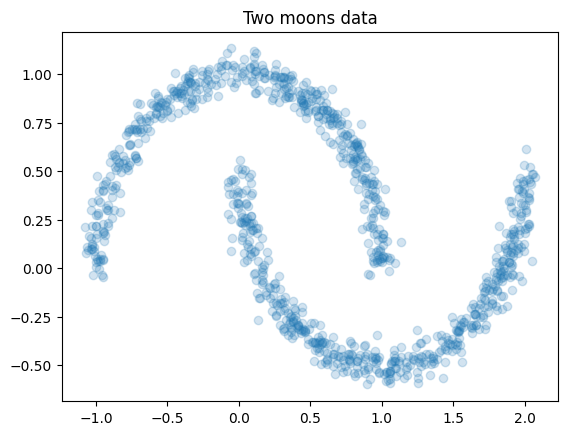

In [7]:
# Visualise the dataset

import matplotlib.pyplot as plt

plt.scatter(train_data[:1000, 0], train_data[:1000, 1], alpha=0.2)
plt.title("Two moons data")
plt.show()

In [8]:
# Create training and validation Datasets

train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
#will see reason for tuple later
train_dataset = train_dataset.map(lambda d: (d, d))
train_dataset = train_dataset.shuffle(500).batch(128).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_data)
val_dataset = val_dataset.map(lambda d: (d, d))
val_dataset = val_dataset.shuffle(500).batch(128).prefetch(tf.data.AUTOTUNE)

#### Define and train the normalising flow

In [9]:
# Define the bijectors chain - NOT NVP

num_layers = 8
bijectors = []
mask = tf.constant([1, 0])

for l in range(num_layers):
    #new shift and log scale for each layer
    shift_and_log_scale = get_shift_and_log_scale_fn(2, hidden_units=[256, 256], 
                                                     activation='relu')
    aff = AffineCouplingLayer(shift_and_log_scale, mask)
    #flip the mask
    mask = 1 - mask
    bijectors.append(aff)
#apply in reverse order of course, starting with first in the loop
realnvp_bijector = tfb.Chain(list(reversed(bijectors)))

In [10]:
# Define a base distribution

#same as last week, base it the base distribution for latent z variables
#not doing the NVP here, so dont change dimension
base = tfd.MultivariateNormalDiag(loc=tf.zeros((2,)), scale_diag=tf.ones((2,)))

In [11]:
# Define the transformed distribution

flow = realnvp_bijector(base)

In [12]:
# Define the model for training

inputs = Input(shape=(2,))
outputs = flow.log_prob(inputs)
realnvp_model = Model(inputs, outputs)

In [13]:
import os
from tensorflow.keras.callbacks import Callback

class SaveSamples(Callback):
    # at each epoch, samples 2000 points from learned normalizing flow and saves plots
    def __init__(self, plot_folder='./plots', **kwargs):
        super(SaveSamples, self).__init__(**kwargs)
        self.plot_folder = plot_folder
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
        
    def plot(self, num):
        plt.figure(figsize=(8, 5))
        ax = plt.gca()
        plt.xlim([-1.5, 2.5])
        plt.ylim([-1, 1.5])
        ax.set_aspect('equal')
        samples = flow.sample(2000)
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3)
        plt.tight_layout()
        plt.savefig("./plots/{:05d}.png".format(num))
        plt.close()
    
    def on_train_begin(self, logs=None):
        if not os.path.exists(self.plot_folder):
            os.makedirs(self.plot_folder)
        self.iteration = 0
        self.plot(self.iteration + 1)

    def on_train_batch_end(self, batch, logs=None):
        self.iteration += 1
        if self.iteration % 30 == 0:
            self.plot((self.iteration // 30) + 1)
        
save_samples = SaveSamples()

In [16]:
# Compile and train the model

#we did the (b,b) thing earlier since it expects input and label, so did it so that the fit method wouldnt complain
#keras always expedt loss to have (true,pred)
def nll(y_true, y_pred):
    #since model outputs log prob
    return -tf.reduce_mean(y_pred)
    
realnvp_model.compile(loss=nll, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
history = realnvp_model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[save_samples])

Epoch 1/20
391/391 [==============================] - 13s 24ms/step - loss: 1.2585 - val_loss: 1.0448
Epoch 2/20
391/391 [==============================] - 8s 22ms/step - loss: 0.9550 - val_loss: 0.8789
Epoch 3/20
391/391 [==============================] - 8s 21ms/step - loss: 0.8510 - val_loss: 0.8373
Epoch 4/20
391/391 [==============================] - 8s 21ms/step - loss: 0.8034 - val_loss: 0.8735
Epoch 5/20
391/391 [==============================] - 9s 23ms/step - loss: 0.7464 - val_loss: 0.7908
Epoch 6/20
391/391 [==============================] - 10s 25ms/step - loss: 0.6836 - val_loss: 0.6392
Epoch 7/20
391/391 [==============================] - 9s 22ms/step - loss: 0.6849 - val_loss: 0.6254
Epoch 8/20
391/391 [==============================] - 8s 21ms/step - loss: 0.6405 - val_loss: 0.6361
Epoch 9/20
391/391 [==============================] - 8s 21ms/step - loss: 0.6323 - val_loss: 0.5964
Epoch 10/20
391/391 [==============================] - 8s 21ms/step - loss: 0.6286 - val_

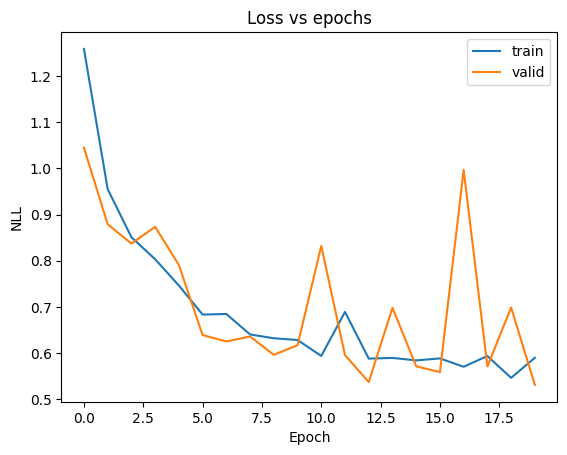

In [17]:
# Plot the learning curves

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title("Loss vs epochs")
plt.ylabel("NLL")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [18]:
# Create a movie file

! ffmpeg -i ./plots/%05d.png -c:v libx264 -vf fps=10 -pix_fmt yuv420p -start_number 00000 samples.mp4

'ffmpeg' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
from IPython.display import Video

Video("samples.mp4")

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

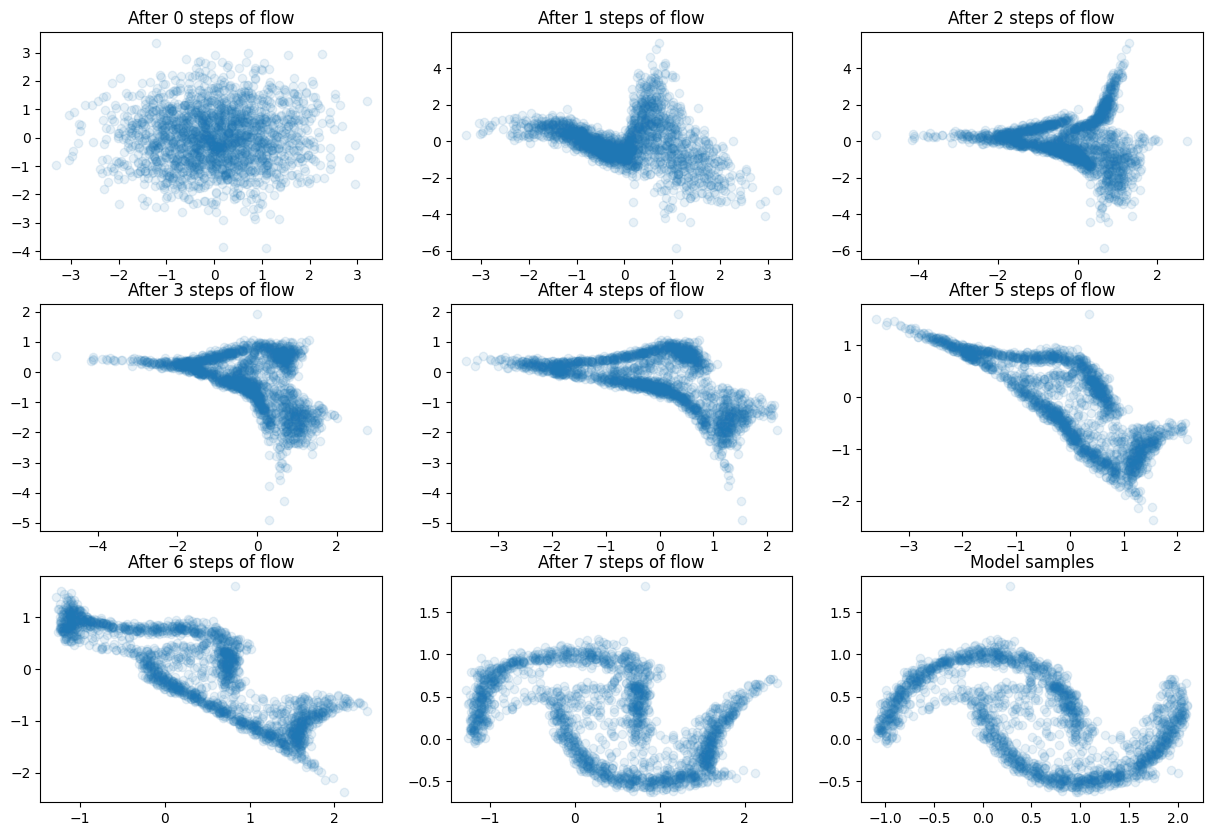

In [22]:
# Plot the model transformations

samples = flow.sample(2000)
noise = realnvp_bijector.inverse(samples)

fig, axs = plt.subplots(3, 3, figsize=(15,10))
h = noise
for i, (bij, ax) in enumerate(zip(bijectors, axs.flat)):
    ax.scatter(h[:, 0], h[:, 1], alpha=0.1)
    ax.set_title(f"After {i} steps of flow")
    h = bij.forward(h)
axs[2, 2].scatter(samples[:, 0], samples[:, 1], alpha=0.1)
axs[2, 2].set_title("Model samples")
plt.show()

In [21]:
# Clean up

filelist = [ f for f in os.listdir('./plots') if f.endswith(".png") ]
for f in filelist:
    os.remove(os.path.join('./plots', f))
if os.path.exists('samples.mp4'):
    os.remove('samples.mp4')

_Exercise._ Try re-running the two moons example again, but using a bi-modal base distribution. Is the flow able to more easily approximate the two moons distributions?

<a class="anchor" id="glow"></a>
## Glow

Glow ([Kingma et al 2018](#Kingma18)) is short for Generative Flow, and this model builds directly from the RealNVP model. It uses the same multiscale architecture setup, where the latent variables are factored out at different levels with the same mechanism as before. 

However, Glow replaces the coupling-squeeze-coupling blocks with a different computation block. The Glow model aims to both simplify the RealNVP architecture, as well as to generalise a part of it. 

As we'll see, Glow still retains the affine coupling layer as the core computation of the model, and also still uses the squeeze operation, and the channel-wise masking. But it removes the checkerboard mask entirely, and also uses a different transformation instead of the alternating mask mechanism of RealNVP.

<img src="figures/glow_schematic.png" alt="Glow multiscale architecture" style="width: 800px;"/>
<center>Glow uses the same multiscale architecture as in RealNVP, but replaces the coupling-squeeze-coupling block</center>

The computation block used in the Glow model is shown in the diagram below.

<img src="figures/glow_step_arrows_labels.png" alt="Glow copmutation block" style="width: 400px;"/>
<center>The computation block used in the Glow model: a squeeze layer, followed by $K$ steps of flow, each consisting of an actnorm layer, an invertible 1x1 convolution, and an affine coupling layer</center>

The squeeze and affine couple layers are the same as in the RealNVP model. The affine coupling layer uses a fixed channel-wise mask. The input to the computation block is first passed through the squeeze layer, which halves each of the spatial dimensions of the input, and multiplies the size of the channel dimension by four.

This is followed by a number of steps of flow, indicated in the diagram above by a green block. A single step of flow consists of an actnorm layer, followed by an invertible 1x1 convolution layer - both of which are new to the Glow model - followed by an affine coupling layer.

Within each level of the Glow model, the squeeze operation is followed by $K$ steps of flow, before half of the neurons are factored out as latent variables as part of the multi scale architecture that we've seen before.

#### Activation normalisation (actnorm)

Actnorm is actually a replacement for the batch normalisation layers that are used within the RealNVP model. Recall that batchnorm is used in RealNVP in the shift and scale networks $s$ and $t$ that are used to parameterise the transformation inside the affine coupling layers. It's also applied to the output of the whole affine coupling layer, and this is where we need to compute the log-Jacobian determinant of the transformation, shown in the following table. Note that $h^{k} \in \mathbb{R}^{H\times W\times C}$, and since mu and sigma are averaged across the spacial dimension, so $\mu_m^{k}, \sigma_m^k \in \mathbb{R}^C$. Finally, $\gamma^k, \beta^k \in \mathbb{R}^C$ since they are used in each spatial location.

| Transformation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| log-Jacobian determinant |
| :--- | --- |
| $\hat{h}_j^{(k)} = \frac{\large h_j^{(k)} - \mu_{jm}^{(k)}}{\sqrt{\left( \sigma_{jm}^{(k)} \right)^2 + \epsilon}} $ |  $ -\frac{1}{2} \sum_j \log \left( \left( \sigma_{jm}^{(k)}\right)^2 + \epsilon \right)$ |
|$z_j^{(k)} = \gamma_j^{(k)}\hat{h}_j^{(k)} + \beta_j^{(k)} $ | $\sum_j \log \left\| \gamma_j^{(k)} \right\|$ |

<center>Batch normalisation transformations and log-Jacobian determinants</center>

The potential problem with batch normalisation is that it relies on minibatch statistics being reasonable estimates of the dataset statistics. If the minibatch statistics are high variance, then this can impact performance. In the case of the original Glow implementation, practical computing constraints meant that the the authors needed to reduce the minibatch size to one, and batchnorm then became less effective.

The solution in the Glow architecture is to introduce actnorm, or activation normalisation, as an alternative to batchnorm. The transformation of actnorm is a simple affine transformation per feature, parameterised by scale and shift parameters gamma and beta:

$$
z_j^{(k)} = \gamma^{(k)}_j h^{(k)}_j + \beta^{(k)}_j,
$$

where the subscript $j$ is indexing the feature dimension and $k$ indexes the layer.

Actnorm does not compute minibatch statistics, which means that the transformation is more stable, but also less flexible, because it's not aware of the statistics of the given input minibatch, and so it's not able to normalise the input activations towards a target mean and variance.

However, the parameters $\gamma^{(k)}_j$ and $\beta^{(k)}_j$ are initialised based on the statistics of a sample minibatch. In particular, they're initialised such that the output activations of the layer have zero mean and unit variance on the given sample minibatch. This is an example of data-dependent initialisation, and is trying to initialise these parameters in a good place for the particular dataset, even though the post-activations will drift away from zero mean and unit variance during training.

Clearly this transformation is trivially invertible so long as all the gammas are nonzero, and in practice these are parameterised to ensure this.

The log-Jacobian determinant is given by 

$$
\sum_j \log \left| \gamma_j^{(k)} \right|,
$$

which is a straightforward and efficient computation.

Note that the expressions above assume rank-one inputs, so that in particular $\mathbf{h}^{(k)}$ would be a vector. When using the Glow model on image inputs, the inputs $\mathbf{h}^{(k)}$ will be 3-dimensional tensors with shape $(h, w, c)$, and the parameters $\gamma^{(k)}_j \in\mathbb{R}^c$ and $\beta^{(k)}_j \in\mathbb{R}^c$ are shared across every spatial location. In this case, the log-Jacobian determinant is multiplied by $hw$.

#### Invertible 1x1 convolution

Recall the following affine coupling layer sequence in RealNVP, that consists of alternating binary channel-wise masks.

<img src="figures/alternating_masks.png" alt="Alternating masks" style="width: 900px;"/>
<center>Three affine coupling layers, with alternating channel masks in between layers</center>

The forward transformation in one of the affine coupling layers can be written as

$$
\mathbf{z} = b\odot \mathbf{x} + (1-b)\odot(\mathbf{x}\odot \exp(s(b\odot \mathbf{x})) + t(b\odot\mathbf{x})),
$$

where $b$ is the channel mask, that zeros out half of the neurons in the channel dimension. RealNVP composes three affine coupling layers together like this, reversing the binary mask each time. 

Instead, we could equivalently think of using a fixed binary mask, and permuting the neurons in the layer in the channel dimension after each affine coupling layer. The permutation matrix $W\in\mathbb{R}^{c\times c}$ would have the following block structure.

$$
W = \left[
\begin{array}{cc}
\mathbf{0} & \mathbf{I} \\
\mathbf{I} & \mathbf{0}
\end{array}
\right]
$$

This same permutation matrix would then be applied at each spatial location. This is a special case of a convolutional layer, where the convolutional kernel has spatial dimensions of 1 by 1, where there is no bias term in the convolutional layer, and where the number of output channels is the same as the number of input channels.

So an equivalent formulation to the sequence of affine coupling layers with an alternating binary channel mask that we looked at before in RealNVP, is where we instead use a 1x1 convolution operation.

The main contribution of the Glow model is to generalise the permutation of the channel dimensions by using a learned 1x1 convolution. This convolutional layer will have the same number of input and output channels, and doesn't use a bias term.

So then we can write the transformation as a 2-dimensional convolution as follows:

$$
\mathbf{h}^{(k+1)} = \text{conv2d}(\mathbf{h}^{(k)}; \mathbf{W}^{(k)}),
$$

where $\mathbf{W}^{(k)}$ is the convolutional kernel. The log Jacobian determinant will then be

$$
h\cdot w \cdot \log~ \left|~ \text{det} (\mathbf{W}^{(k)})~\right|,
$$

where $h$ and $w$ are the sizes of the height and width dimensions respectively.

The problem here is that it can be expensive to compute the determinant of the convolutional kernel $\mathbf{W}^{(k)}$. This computation scales as $\mathcal{O}(c^3)$, where $c$ is the number of channels.

A solution to this problem is to use the LU decomposition of the $c\times c$ matrix $\mathbf{W}^{(k)}$:

$$
\mathbf{W}^{(k)} = \mathbf{P}^{(k)} \mathbf{L}^{(k)} \left( \mathbf{U}^{(k)} + \text{diag}\left(\mathbf{s}^{(k)}\right) \right).
$$

In the above, $\mathbf{P}^{(k)}$ is some permutation matrix, $\mathbf{L}^{(k)}$ is lower triangular with ones on the diagonal, $\mathbf{U}^{(k)}$ is upper triangular, and we have separated out the diagonal elements so that $\mathbf{U}^{(k)}$ is upper triangular with zeros on the diagonal, and the diagonal elements are written as the diagonalisation of a vector $\mathbf{s}^{(k)}$.

In practical implementations, we can directly parameterise the convolutional kernel as in the above expression. The log Jacobian determinant can now be written as $h$ times $w$ times the sum of the log of the absolute values of the elements of the vector $\mathbf{s}^{(k)}$. This computation now scales as $\mathcal{O}(c)$, so is much more efficient.

The Glow paper initialises the convolutional kernel $\mathbf{W}^{(k)}$ as a random rotation matrix, and computes the LU decomposition in order to initialise the parameterisation you see above. This will set the permutation matrix $\mathbf{P}^{(k)}$, which remains fixed throughout the training. The matrices $\mathbf{L}^{(k)}$ and $\mathbf{U}^{(k)}$ as well as the vector $\mathbf{s}^{(k)}$ are all learned during training.

#### Affine Coupling Layer

The third layer in a single step of flow is the affine coupling layer with a (fixed) binary channel-wise mask $b$. The forward transformation and the log-Jacobian determinant are shown again below.

<img src="figures/realnvp_forward.png" alt="RealNVP: forward pass" style="width: 400px;"/>

| Transformation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| log-Jacobian determinant |
| :--- | --- |
| $\mathbf{z} = b\odot \mathbf{x} + (1-b)\odot(\mathbf{x}\odot \exp(s(b\odot \mathbf{x})) + t(b\odot\mathbf{x}))$ | $\sum_j \log \left| s_j \right| $ |

----

The actnorm, invertible 1x1 convolution and affine coupling layers are the three layers that make up a single step of flow of the Glow model. Within each level of the Glow architecture, the inputs are first passed through the squeeze layer, and through $K$ steps of flow, before half of the neurons are factored out as latent variables. The remaining neurons continue on for further processing. This is the same multi scale architecture we saw in the RealNVP model.

<a class="anchor" id="references"></a>
## References

<a class="anchor" id="Dinh15"></a>
* Dinh, L., Krueger, D. & Bengio, Y. (2015),"NICE: Non-linear Independent Components Estimation", in *3rd International Conference on Learning Representations, (ICLR)*, San Diego, CA, USA, May 7-9, 2015.
<a class="anchor" id="Dinh17"></a>
* Dinh, L., Sohl-Dickstein, J. & Bengio, S. (2017), "Density estimation using Real NVP",  in *5th International Conference on Learning Representations, (ICLR)*, Toulon, France, April 24-26, 2017.
<a class="anchor" id="Kingma18"></a>
* Kingma, D. P. & Dhariwal, P. (2018), "Glow: Generative Flow with Invertible 1x1 Convolutions", in *Advances in Neural Information Processing Systems*, **31**, 10215--10224.